In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from pathlib import Path
import datetime as dt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import cv2

from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp

При написании кода использованы некоторые подходы из источника: https://www.kaggle.com/julichitai/lips-segmentation-pytorch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
DATASET_FILEPATH = Path('./input/set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [4]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [5]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [6]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [7]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

In [8]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [9]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [10]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

In [11]:
# Переменные определяемые выбранной сетью
BACKBONE = 'resnet34'
IMG_SIZE = 256

In [12]:
# Предварительная обработка исходного изображения
preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [13]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask

## Вариант по материалам урока

In [14]:
class CustomDatasetFromImages(Dataset):
    
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing

        self.images_paths = self.data.iloc[:,0]
        self.masks_paths = self.data.iloc[:,1]
        self.data_len = len(self.data.index)
   
    def __getitem__(self, index):
        img_path = self.images_paths[index]
        mask_path = self.masks_paths[index]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)

        img = img.astype(float)
        img = torch.as_tensor(self.preprocessing(img)) if self.preprocessing else torch.as_tensor(img)/255
        img = img.unsqueeze(0).permute(0,3,1,2)
        
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')

        mask = torch.as_tensor(cls_mask_1).unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

Пример изображения и его маски

In [15]:
train_data = CustomDatasetFromImages(X_train)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

torch.Size([1, 1, 3, 256, 256])
torch.Size([1, 1, 1, 256, 256])
tensor(0.) tensor(1.)


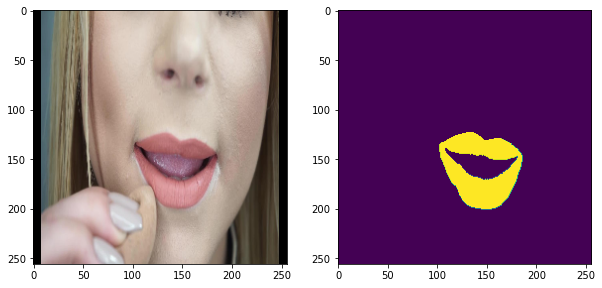

In [16]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0,0,:,:].permute(1, 2, 0))
    ax[1].imshow(masks[0,0,:,:].permute(1, 2, 0))
    break

Класс для обучения и предсказаний

In [17]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        train_preprocessing: преобразования тренировочных данных
        valid_preprocessing: преобразования валидационных данных
        
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество батчей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        
        optim: оптимизатор
        params_to_update: список обучаемых параметров
        
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f,
                 train_preprocessing=None,
                 valid_preprocessing=None,
                 learning_rate=1e-3, 
                 epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None,
                 device='cpu', early_stopping=10,
                 optim=torch.optim.Adam,
                 params_to_update=None,
                 scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        
        self.optim = optim
        self.params_to_update = params_to_update
        
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.train_preprocessing = train_preprocessing
        self.valid_preprocessing = valid_preprocessing
        
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []
    
    def predict(self, X):
        return self.best_model(X)

    def fit(self, train_dataset, valid_dataset):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        if self.params_to_update is not None:
            optimizer = self.optim(self.params_to_update, lr=self.learning_rate)
        else:
            optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(train_dataset, self.train_preprocessing)
        val = self.dataset(valid_dataset, self.valid_preprocessing)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X[0])
                #print(batch_X.shape)
                #print(predicted_values.shape)
                #print(target.shape)
                #return
            
                loss = self.loss_f(predicted_values, target[0,0,:,:,:])
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X[0])
                loss = self.loss_f(predicted_values, target[0,0,:,:,:])

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

    def save_model(self, PATH):
        torch.save(self.best_model.state_dict(), PATH)

    def load_model(self, PATH):
         self.best_model.load_state_dict(torch.load(PATH))       

Loss-функция

In [18]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    #print(ignore_index)
    #print(output.shape)
    #print(target.shape)

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

Loss-класс

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weights=None, ignore_index=None):
        super().__init__()
        self.weights = weights
        self.ignore_index = ignore_index
        
    def forward(self, yhat, y):
        return dice_loss(yhat, y, weights=self.weights, ignore_index=self.ignore_index)

Сеть

In [20]:
segmodel = smp.Unet(encoder_name=BACKBONE, classes=2, activation='sigmoid')

In [21]:
params = {
    'dataset': CustomDatasetFromImages,
    'train_preprocessing': preprocess_input,
    'valid_preprocessing': preprocess_input,
    'net': segmodel,
    'batch_size': 1,
    'max_batches_per_epoch': 1200, #ограничим количество батчей на эпохе, чтобы сократить время обучения 
    'epoch_amount': 10, 
    'learning_rate': 1e-3,
    'early_stopping': 3,
    'loss_f': DiceLoss(),
    'optim': torch.optim.Adam,
    'device': device
}

clf1 = Trainer(**params)

In [22]:
clf1.fit(X_train, X_valid)

Эпоха: 0 Loss_train: 0.2610375705609719, 0:13:36.260265 сек
Loss_val: 0.2674461901187897

Эпоха: 1 Loss_train: 0.2577143481373787, 0:13:53.994779 сек
Loss_val: 0.2660529613494873

Эпоха: 2 Loss_train: 0.2571907416979472, 0:12:50.381444 сек
Loss_val: 0.2669984698295593

Эпоха: 3 Loss_train: 0.25779784945150214, 0:13:48.818014 сек
Loss_val: 0.26623931527137756

Эпоха: 4 Loss_train: 0.25820321527620155, 0:13:38.361154 сек
Loss_val: 0.2686970829963684

Эпоха: 5 Loss_train: 0.2572972506781419, 0:13:32.824665 сек
Loss_val: 0.26505935192108154

Эпоха: 6 Loss_train: 0.2561028638482094, 0:12:43.039603 сек
Loss_val: 0.2649569511413574

Эпоха: 7 Loss_train: 0.2576750153551499, 0:12:36.478227 сек
Loss_val: 0.26710444688796997

Эпоха: 8 Loss_train: 0.25744859966139, 0:13:21.063350 сек
Loss_val: 0.2663077116012573

Эпоха: 9 Loss_train: 0.2567682870725791, 0:13:51.388113 сек
Loss_val: 0.26457658410072327



In [23]:
train_data = CustomDatasetFromImages(X_train)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

torch.Size([1, 1, 3, 256, 256])
torch.Size([1, 1, 1, 256, 256])
tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]])
torch.Size([1, 2, 256, 256])


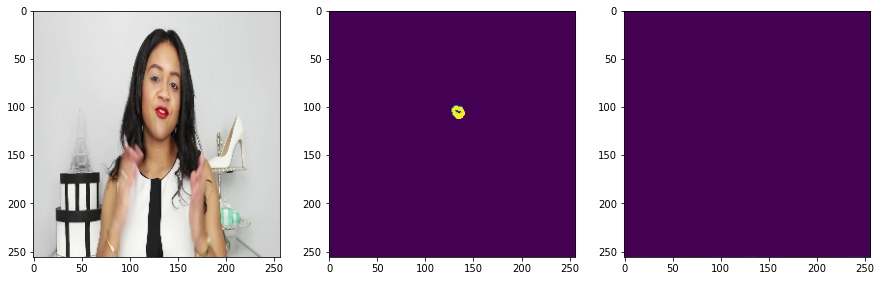

In [24]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks)
    
    outputs = clf1.predict(imgs[0])
    print(outputs.shape)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    ax[0].imshow(imgs[0,0,:,:].permute(1, 2, 0))
    ax[1].imshow(masks[0,0,:,:].permute(1, 2, 0))
    ax[2].imshow(outputs[0,1:,:,:].permute(1, 2, 0).detach().cpu().numpy())
    break

## Вариант по материалам kaggle

In [25]:
class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        
        img = img.astype(float)
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        img = img.permute(2, 0, 1)
      
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')

        masks = np.array([cls_mask_1])
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return img.float(), masks

In [26]:
segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [27]:
train_data = LipsDataset(X_train[:1200], preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid[:400], preprocessing=preprocess_input)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=False)

In [28]:
#criterion = smp.utils.losses.BCELoss()
criterion = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [29]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [30]:
max_score = 0

for i in range(0, 10):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train:   0%|                                                                                   | 0/150 [00:00<?, ?it/s]

C:\Users\Kartsev.ES\AppData\Local\Temp/ipykernel_20444/978772449.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  masks = torch.as_tensor(masks, dtype=torch.float)


valid: 100%|████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s, dice_loss - 0.9775, iou_score - 0.01151]
Model saved!
Epoch: 2
valid: 100%|█████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s, dice_loss - 0.1907, iou_score - 0.7068]
Model saved!
Epoch: 3
valid: 100%|████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s, dice_loss - 0.07692, iou_score - 0.8674]
Model saved!
Epoch: 4
valid: 100%|██████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s, dice_loss - 0.1012, iou_score - 0.834]
Epoch: 5
valid: 100%|████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s, dice_loss - 0.05169, iou_score - 0.9077]
Model saved!
Epoch: 6
valid: 100%|████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s, dice_loss - 0.04529, iou_score - 0.9189]
Model saved!
Epoch: 7
valid: 100%|████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s, dice_loss - 0.05468, iou_score - 0.9016]
Epoch: 8
valid: 100%|████████████████████

In [31]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

In [32]:
outputs = segmodel(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


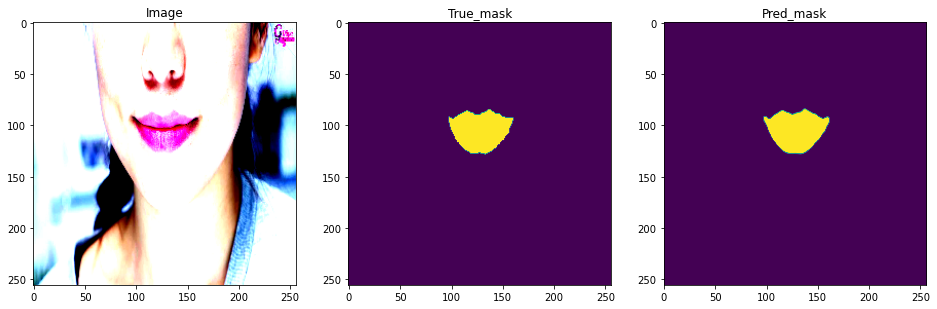

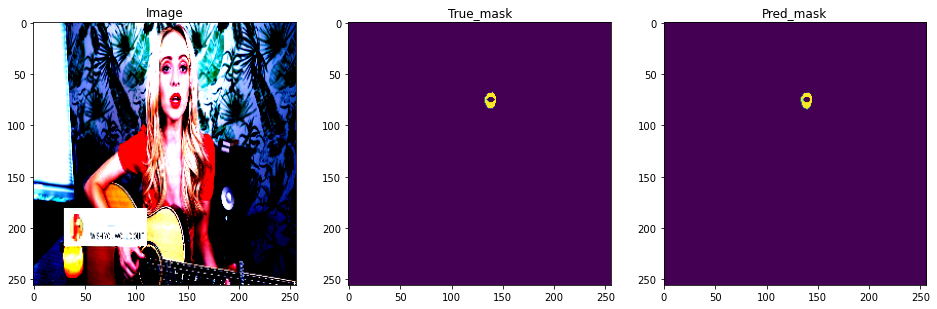

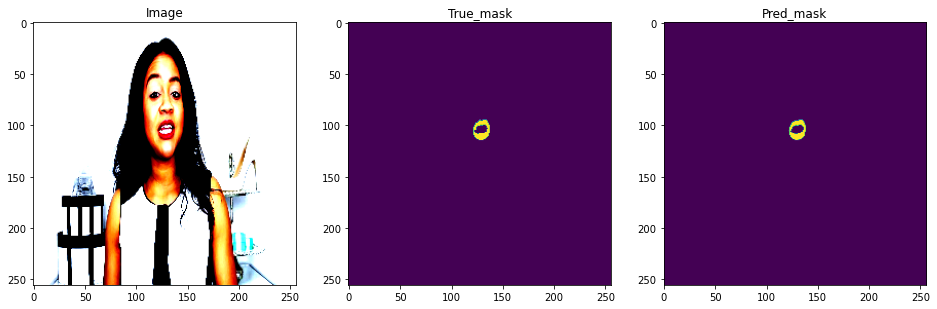

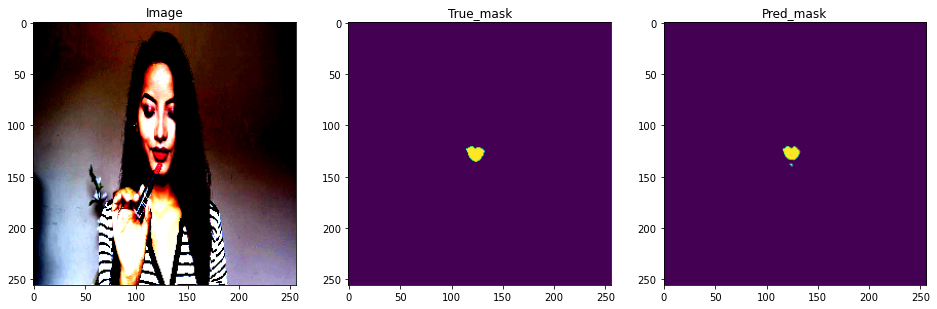

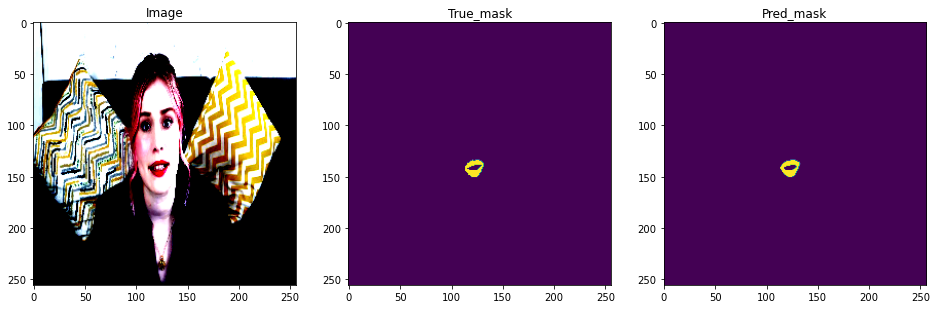

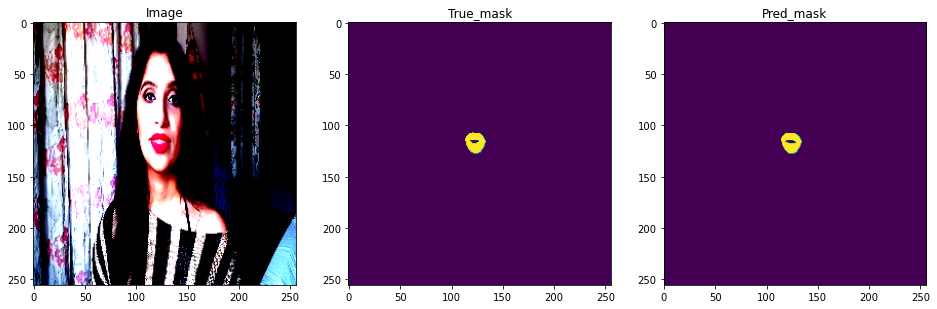

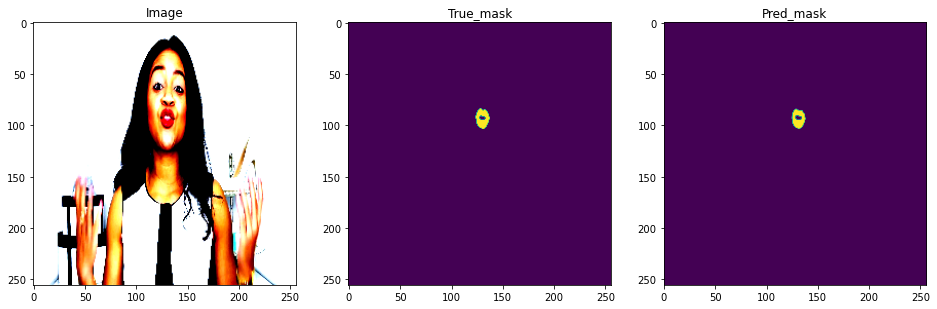

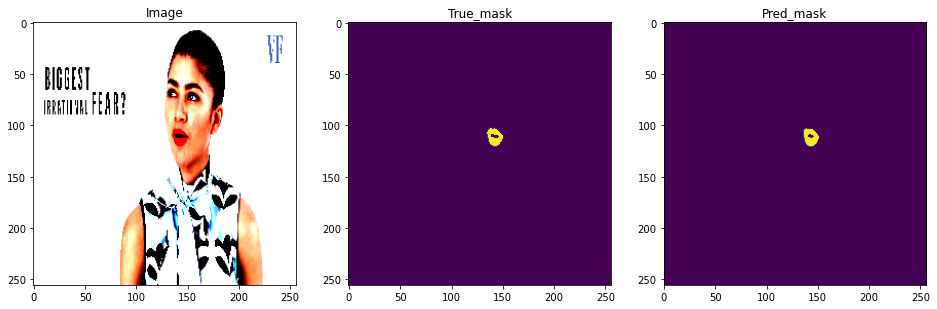

In [33]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i,].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')